In [76]:
# Imports. Nothing to see here.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import random

import sqlite3
from textblob import TextBlob
from wordcloud import WordCloud

import pickle

In [77]:
# databases within ['categories', 'podcasts', 'reviews', 'runs']

cnx = sqlite3.connect('D:\Flatiron\Capstone\database.sqlite')

podcast = pd.read_sql_query("SELECT * FROM podcasts", cnx)

categories = pd.read_sql_query("SELECT * FROM categories", cnx)

runs = pd.read_sql_query("SELECT * FROM runs", cnx)

reviews = pd.read_sql_query("SELECT * FROM reviews", cnx)

In [78]:
explore = pd.read_sql_query('''SELECT p.podcast_id, AVG(rating)
                            FROM podcasts p 
                            JOIN categories c 
                            ON p.podcast_id = c.podcast_id 
                            JOIN reviews r 
                            ON p.podcast_id = r.podcast_id 
                            GROUP BY p.podcast_id
                            ORDER BY AVG(rating)
                            ''', cnx)
explore


podcast_id  AVG(rating)
0      a0004b1ef445af9dc84dad1e7821b1e3          1.0
1      a024f5f647d0877820ef9f4a8584f93a          1.0
2      a03abf5b7f0f58615ea36f0f8c4cefcc          1.0
3      a0459e0af7b8be2c886e867d58f1dedd          1.0
4      a05087d5a58f032cbc27562166f10186          1.0
...                                 ...          ...
46660  fffdfb5b49d0d47943e09f6213a346e5          5.0
46661  fffe308414050768d3ce3782aa503b7d          5.0
46662  fffe3f208a56dfecfaf6d0a7f8399d63          5.0
46663  ffff66f98c1adfc8d0d6c41bb8facfd0          5.0
46664  ffff923482740bc21a0fe184865ec2e2          5.0

[46665 rows x 2 columns]

In [79]:
data = pd.read_sql_query("SELECT * FROM podcasts p JOIN categories c USING (podcast_id) JOIN reviews r USING (podcast_id)", cnx)

In [80]:
data.head()

podcast_id   itunes_id                        slug  \
0  c61aa81c9b929a66f0c1db6cbe5d8548  1373261997  backstage-at-tilles-center   
1  c61aa81c9b929a66f0c1db6cbe5d8548  1373261997  backstage-at-tilles-center   
2  c61aa81c9b929a66f0c1db6cbe5d8548  1373261997  backstage-at-tilles-center   
3  c61aa81c9b929a66f0c1db6cbe5d8548  1373261997  backstage-at-tilles-center   
4  c61aa81c9b929a66f0c1db6cbe5d8548  1373261997  backstage-at-tilles-center   

                                          itunes_url  \
0  https://podcasts.apple.com/us/podcast/backstag...   
1  https://podcasts.apple.com/us/podcast/backstag...   
2  https://podcasts.apple.com/us/podcast/backstag...   
3  https://podcasts.apple.com/us/podcast/backstag...   
4  https://podcasts.apple.com/us/podcast/backstag...   

                        title              category  \
0  Backstage at Tilles Center                  arts   
1  Backstage at Tilles Center  arts-performing-arts   
2  Backstage at Tilles Center                 music   
3  Backstage at Tilles Center                  arts   
4  Backstage at Tilles Center  arts-performing-arts   

                                              title  \
0                               really interesting!   
1                               really interesting!   
2                               really interesting!   
3  Must listen for anyone interested in the arts!!!   
4  Must listen for anyone interested in the arts!!!   

                                             content  rating  \
0  Thanks for providing these insights.  Really e...       5   
1  Thanks for providing these insights.  Really e...       5   
2  Thanks for providing these insights.  Really e...       5   
3  Super excited to see this podcast grow. So man...       5   
4  Super excited to see this podcast grow. So man...       5   

                  created_at  
0  2018-04-24T12:05:16-07:00  
1  2018-04-24T12:05:16-07:00  
2  2018-04-24T12:05:16-07:00  
3  2018-05-09T18:14:32-07:00  
4  2018-05-09T18:14:32-07:00

In [81]:
count = len(set(data['category']))
count

26

In [82]:
# plt.hist(data['podcast_id'])
# plt.show()

In [83]:
print(data.shape)
data['podcast_id'].nunique()

(1425165, 10)


46665

In [84]:
data.drop(['itunes_url','itunes_id', 'created_at', 'title'], axis=1, inplace=True)

In [85]:
print(data.isna().sum())

podcast_id    0
slug          0
category      0
content       0
rating        0
dtype: int64


In [86]:
# Check for duplicated rows and preserve unique entries.

a = len(data)
data = data.drop_duplicates()
b = len(data)
print('# Number of duplicate rows dropped: {}'.format(a-b))

# Number of duplicate rows dropped: 2967


In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1422198 entries, 0 to 1425164
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   podcast_id  1422198 non-null  object
 1   slug        1422198 non-null  object
 2   category    1422198 non-null  object
 3   content     1422198 non-null  object
 4   rating      1422198 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 65.1+ MB


In [88]:
data.shape

(1422198, 5)

In [89]:
data['category'].unique()

array(['arts', 'arts-performing-arts', 'music', 'arts-design',
       'education', 'society-culture', 'arts-visual-arts', 'technology',
       'arts-food', 'society-culture-personal-journals', 'comedy',
       'arts-fashion-beauty', 'tv-film', 'society-culture-places-travel',
       'kids-family', 'religion-spirituality', 'business',
       'society-culture-philosophy', 'spirituality', 'business-careers',
       'christianity', 'hinduism', 'business-investing', 'judaism',
       'islam', 'buddhism'], dtype=object)

In [90]:
tokenizer = RegexpTokenizer(r'\w+')

stops = stopwords.words('english')
stops += list(string.punctuation)
stops += ['podcast', 'listen', 'listening']

In [91]:
data

podcast_id  \
0        c61aa81c9b929a66f0c1db6cbe5d8548   
1        c61aa81c9b929a66f0c1db6cbe5d8548   
2        c61aa81c9b929a66f0c1db6cbe5d8548   
3        c61aa81c9b929a66f0c1db6cbe5d8548   
4        c61aa81c9b929a66f0c1db6cbe5d8548   
...                                   ...   
1425160  ddd451a18055f0108edf79f8c3c9bf15   
1425161  a08a93f2ef58f847b263c84d96e891f5   
1425162  f9255ade54a8e12df362cde70b49dff9   
1425163  f9255ade54a8e12df362cde70b49dff9   
1425164  cf6b01b278eaa01a3e7bdb607ebc3d66   

                                                      slug  \
0                               backstage-at-tilles-center   
1                               backstage-at-tilles-center   
2                               backstage-at-tilles-center   
3                               backstage-at-tilles-center   
4                               backstage-at-tilles-center   
...                                                    ...   
1425160                     what-if-world-stories-for-kids   
1425161  inbox-besties-w-kate-doster-email-marketing-po...   
1425162                                         the-trypod   
1425163                                         the-trypod   
1425164     root-evil-true-story-hodel-family-black-dahlia   

                     category  \
0                        arts   
1        arts-performing-arts   
2                       music   
3                        arts   
4        arts-performing-arts   
...                       ...   
1425160           kids-family   
1425161              business   
1425162                comedy   
1425163                comedy   
1425164       society-culture   

                                                   content  rating  
0        Thanks for providing these insights.  Really e...       5  
1        Thanks for providing these insights.  Really e...       5  
2        Thanks for providing these insights.  Really e...       5  
3        Super excited to see this podcast grow. So man...       5  
4        Super excited to see this podcast grow. So man...       5  
...                                                    ...     ...  
1425160  I made this so all you guys that listen to thi...       5  
1425161  I just discovered Kate Doster and the hype is ...       5  
1425162  This podcast as well as the “you can sit with ...       1  
1425163  Really crappy ep 2/4. I guess they can’t all b...       1  
1425164  Very well presented story! Sad to have happene...       5  

[1422198 rows x 5 columns]

In [92]:
data ['slug'] = data['slug'].apply(lambda x: x.replace('-',' '))
data ['category'] = data['category'].apply(lambda x: x.replace('-',' '))
data ['category'] = data['category'].apply(lambda x: x.split()[0])
data

podcast_id  \
0        c61aa81c9b929a66f0c1db6cbe5d8548   
1        c61aa81c9b929a66f0c1db6cbe5d8548   
2        c61aa81c9b929a66f0c1db6cbe5d8548   
3        c61aa81c9b929a66f0c1db6cbe5d8548   
4        c61aa81c9b929a66f0c1db6cbe5d8548   
...                                   ...   
1425160  ddd451a18055f0108edf79f8c3c9bf15   
1425161  a08a93f2ef58f847b263c84d96e891f5   
1425162  f9255ade54a8e12df362cde70b49dff9   
1425163  f9255ade54a8e12df362cde70b49dff9   
1425164  cf6b01b278eaa01a3e7bdb607ebc3d66   

                                                      slug  category  \
0                               backstage at tilles center      arts   
1                               backstage at tilles center      arts   
2                               backstage at tilles center     music   
3                               backstage at tilles center      arts   
4                               backstage at tilles center      arts   
...                                                    ...       ...   
1425160                     what if world stories for kids      kids   
1425161  inbox besties w kate doster email marketing po...  business   
1425162                                         the trypod    comedy   
1425163                                         the trypod    comedy   
1425164     root evil true story hodel family black dahlia   society   

                                                   content  rating  
0        Thanks for providing these insights.  Really e...       5  
1        Thanks for providing these insights.  Really e...       5  
2        Thanks for providing these insights.  Really e...       5  
3        Super excited to see this podcast grow. So man...       5  
4        Super excited to see this podcast grow. So man...       5  
...                                                    ...     ...  
1425160  I made this so all you guys that listen to thi...       5  
1425161  I just discovered Kate Doster and the hype is ...       5  
1425162  This podcast as well as the “you can sit with ...       1  
1425163  Really crappy ep 2/4. I guess they can’t all b...       1  
1425164  Very well presented story! Sad to have happene...       5  

[1422198 rows x 5 columns]

In [93]:
# data['all'] = data['slug'] + ' ' + data['content']

In [94]:
data['content'] = data['content'].apply(tokenizer.tokenize)

data['content'] = data['content'].apply(lambda x: [word.lower() for word in x if word.lower() not in stops])

In [95]:
# data.drop(['slug', 'content'], axis = 1, inplace=True)

In [134]:
data.to_pickle('./data')

In [97]:
podcast['podcast_id'].nunique()

46665

In [98]:
############################ Visualize this ##############################

data['rating'].value_counts()

5    1265761
1      60381
4      41631
3      29006
2      25419
Name: rating, dtype: int64

(array([  60381.,       0.,   25419.,       0.,       0.,   29006.,
              0.,   41631.,       0., 1265761.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

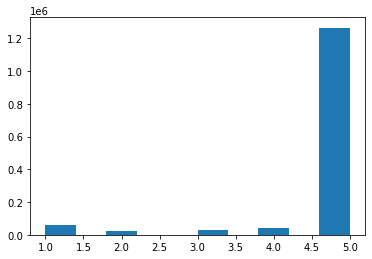

In [99]:
plt.hist(data['rating'])

# Functions

In [100]:
def tf_idf(X_train, X_test):
    tfidf = TfidfVectorizer()
    X_train_counts = tfidf.fit_transform(X_train)
    X_test_counts = tfidf.transform(X_test)
    return X_test_counts, X_train_counts

In [101]:
# Lemmatizing will or won't happen. Two functions, one nested inside the other.
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

def lemmatize():
    data['lemm'] = data['content'].apply(lemmatize_text)
    data['lemm'] = data['lemm'].apply(lambda x: ' '.join(x))

In [102]:
# SMOTE either will or will not run.
def smote(X_train_counts, y_train):
    smote = SMOTE()
    X_train_counts, y_train = smote.fit_sample(X_train_counts, y_train)
    return X_train_counts, y_train

# Train Test Split. The col variable is important and will be different depending on whether we lemmatize.
def TTS(col):
    X_train, X_test, y_train, y_test = train_test_split(data[col], data['feelings'])
    return X_train, X_test, y_train, y_test

In [103]:
def classify(y_test, y_predicted_counts):
    print('\n\nClassification Report - TEST')
    print('--------------------------------------------------------------------------')
    print(classification_report(y_test, y_predicted_counts))
    print('--------------------------------------------------------------------------')
    print('Confusion Matrix - TEST')
    print('--------------------------------------------------------------------------')
    print(pd.crosstab(y_test, y_predicted_counts, rownames=['True'], colnames=['Predicted'], margins=True))
    print('--------------------------------------------------------------------------')

In [104]:
lemmatize()

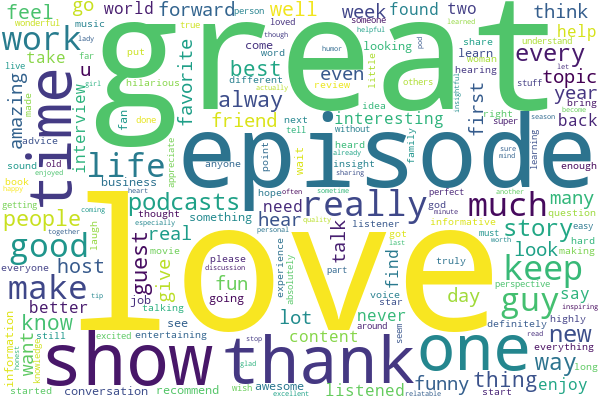

In [105]:
long_string = ','.join(list(data['lemm'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=200, height=400, width=600, contour_width=3, contour_color='steelblue', collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# TextBlob

In [106]:
# Initializing the TextBlob sentiment for subj/polar(+/-)
polarity = (lambda x: TextBlob(x).sentiment.polarity)
subjectivity = (lambda x: TextBlob(x).sentiment.subjectivity)
# Applying to dataframe column with cleaned/tokenized text
data['polarity'] = data['lemm'].apply(polarity)
data['subjectivity'] = data['lemm'].apply(subjectivity)


In [107]:
# # Check the output
# data[['polarity', 'subjectivity']][0:5]

In [108]:
# plt.bar(data.shape[0],data['polarity'])
# plt.show()

In [109]:
# # Returned as numbers on spectrum - polar is -1 to 1 scale
# # Subjectivity is 0 to 1
# # Bin into positive, negative, and neutral sentiments
# # Neutral is between -0.05 to 0.05 - this can be adjusted
# def get_sentiment(row):
#         if row > 0.05:
#             return 'Positive'
#         elif row < -0.05:
#             return 'Negative'
#         else:
#             return 'Neutral'
# data['polarity_label'] = data['polarity'].apply(get_sentiment)

In [110]:
# data.polarity_label.value_counts().plot(kind='bar', color='gold', alpha=0.6, figsize = (14, 8))
# plt.show()

In [111]:
tfidf = TfidfVectorizer()
tf = tfidf.fit_transform(data['lemm'])


In [112]:
tf2 = tfidf.fit(data['lemm'])

In [113]:
# pickle.dump(tf2, open("tf.p", "wb" ))

In [114]:
# clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
#                          multi_class='multinomial', n_jobs=-1, random_state=40)
# clf.fit(tf, data['rating'])

LogisticRegression(C=30.0, class_weight='balanced', multi_class='multinomial',
                   n_jobs=-1, random_state=40, solver='newton-cg')

In [135]:
clf_pickle = pickle.dumps(clf)

In [136]:
clf = pickle.loads(clf_pickle)

In [115]:
y_predicted_counts = clf.predict(tf)

In [116]:
data['predict'] = y_predicted_counts

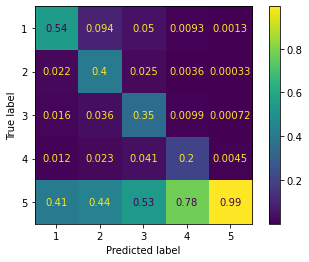

In [117]:
plot_confusion_matrix(clf, tf, data['rating'], normalize='pred')

In [118]:
data

podcast_id  \
0        c61aa81c9b929a66f0c1db6cbe5d8548   
1        c61aa81c9b929a66f0c1db6cbe5d8548   
2        c61aa81c9b929a66f0c1db6cbe5d8548   
3        c61aa81c9b929a66f0c1db6cbe5d8548   
4        c61aa81c9b929a66f0c1db6cbe5d8548   
...                                   ...   
1425160  ddd451a18055f0108edf79f8c3c9bf15   
1425161  a08a93f2ef58f847b263c84d96e891f5   
1425162  f9255ade54a8e12df362cde70b49dff9   
1425163  f9255ade54a8e12df362cde70b49dff9   
1425164  cf6b01b278eaa01a3e7bdb607ebc3d66   

                                                      slug  category  \
0                               backstage at tilles center      arts   
1                               backstage at tilles center      arts   
2                               backstage at tilles center     music   
3                               backstage at tilles center      arts   
4                               backstage at tilles center      arts   
...                                                    ...       ...   
1425160                     what if world stories for kids      kids   
1425161  inbox besties w kate doster email marketing po...  business   
1425162                                         the trypod    comedy   
1425163                                         the trypod    comedy   
1425164     root evil true story hodel family black dahlia   society   

                                                   content  rating  \
0        [thanks, providing, insights, really, enjoy, v...       5   
1        [thanks, providing, insights, really, enjoy, v...       5   
2        [thanks, providing, insights, really, enjoy, v...       5   
3        [super, excited, see, grow, many, fun, topics,...       5   
4        [super, excited, see, grow, many, fun, topics,...       5   
...                                                    ...     ...   
1425160  [made, guys, fun, spot, difference, number, 2,...       5   
1425161  [discovered, kate, doster, hype, real, heard, ...       5   
1425162  [well, sit, us, turned, 30, minutes, actual, c...       1   
1425163  [really, crappy, ep, 2, 4, guess, winners, wou...       1   
1425164  [well, presented, story, sad, happened, hodel,...       5   

                                                      lemm  polarity  \
0        thanks providing insight really enjoy variety ...  0.300000   
1        thanks providing insight really enjoy variety ...  0.300000   
2        thanks providing insight really enjoy variety ...  0.300000   
3        super excited see grow many fun topic talk sha...  0.308333   
4        super excited see grow many fun topic talk sha...  0.308333   
...                                                    ...       ...   
1425160  made guy fun spot difference number 2 number 3... -0.288889   
1425161  discovered kate doster hype real heard person ...  0.193750   
1425162  well sit u turned 30 minute actual content 25 ... -0.100000   
1425163  really crappy ep 2 4 guess winner would really...  0.155363   
1425164  well presented story sad happened hodel family... -0.105556   

         subjectivity  predict  
0            0.350000        5  
1            0.350000        5  
2            0.350000        5  
3            0.545238        5  
4            0.545238        5  
...               ...      ...  
1425160      0.733333        5  
1425161      0.362500        5  
1425162      0.250000        1  
1425163      0.470611        4  
1425164      0.661111        5  

[1422198 rows x 9 columns]

In [119]:
len(y_predicted_counts)

1422198

In [120]:
filtered = data[data['rating'] != data['predict']]
filtered

podcast_id                     slug   category  \
12       ad4f2bf69c72b8db75978423c25f379e          ted talks daily       arts   
13       ad4f2bf69c72b8db75978423c25f379e          ted talks daily       arts   
14       ad4f2bf69c72b8db75978423c25f379e          ted talks daily  education   
18       ad4f2bf69c72b8db75978423c25f379e          ted talks daily       arts   
19       ad4f2bf69c72b8db75978423c25f379e          ted talks daily       arts   
...                                   ...                      ...        ...   
1425128  f3c611ee25d6b3f0efca2f2f86fb114b  stolen lives true crime    society   
1425134  bd39dd4c1a5d156af80b8b1ac8a8e50d           sleep whispers    society   
1425135  bd39dd4c1a5d156af80b8b1ac8a8e50d           sleep whispers    society   
1425155  f599da38fa69271b49f2dbbf56686874            conversations    society   
1425163  f9255ade54a8e12df362cde70b49dff9               the trypod     comedy   

                                                   content  rating  \
12                                            [love, good]       5   
13                                            [love, good]       5   
14                                            [love, good]       5   
18       [much, bs, trying, convince, racist, sexist, c...       3   
19       [much, bs, trying, convince, racist, sexist, c...       3   
...                                                    ...     ...   
1425128  [stories, sad, children, need, protected, keep...       5   
1425134  [one, top, asmr, sleep, whisper, podcasts, get...       5   
1425135  [one, top, asmr, sleep, whisper, podcasts, get...       5   
1425155  [richard, engaged, engaging, sarah, k, however...       5   
1425163  [really, crappy, ep, 2, 4, guess, winners, wou...       1   

                                                      lemm  polarity  \
12                                               love good  0.600000   
13                                               love good  0.600000   
14                                               love good  0.600000   
18       much b trying convince racist sexist country m...  0.200000   
19       much b trying convince racist sexist country m...  0.200000   
...                                                    ...       ...   
1425128  story sad child need protected keep good work ...  0.300000   
1425134  one top asmr sleep whisper podcasts get excite...  0.346591   
1425135  one top asmr sleep whisper podcasts get excite...  0.346591   
1425155  richard engaged engaging sarah k however like ...  0.400000   
1425163  really crappy ep 2 4 guess winner would really...  0.155363   

         subjectivity  predict  
12           0.600000        4  
13           0.600000        4  
14           0.600000        4  
18           0.200000        1  
19           0.200000        1  
...               ...      ...  
1425128      0.733333        3  
1425134      0.613636        1  
1425135      0.613636        1  
1425155      0.700000        4  
1425163      0.470611        4  

[249550 rows x 9 columns]

In [121]:
filtered['rating'].value_counts().sort_index()

1     10991
2      4571
3      5682
4      9713
5    218593
Name: rating, dtype: int64

In [122]:
# % of total ratings that were misclassified

np.array(filtered['rating'].value_counts().sort_index()) / np.array(data['rating'].value_counts().sort_index())

array([0.18202746, 0.17982611, 0.19589051, 0.23331171, 0.1726969 ])

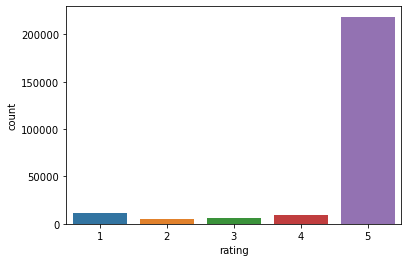

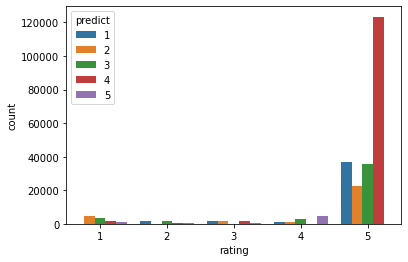

<AxesSubplot:xlabel='rating', ylabel='count'>

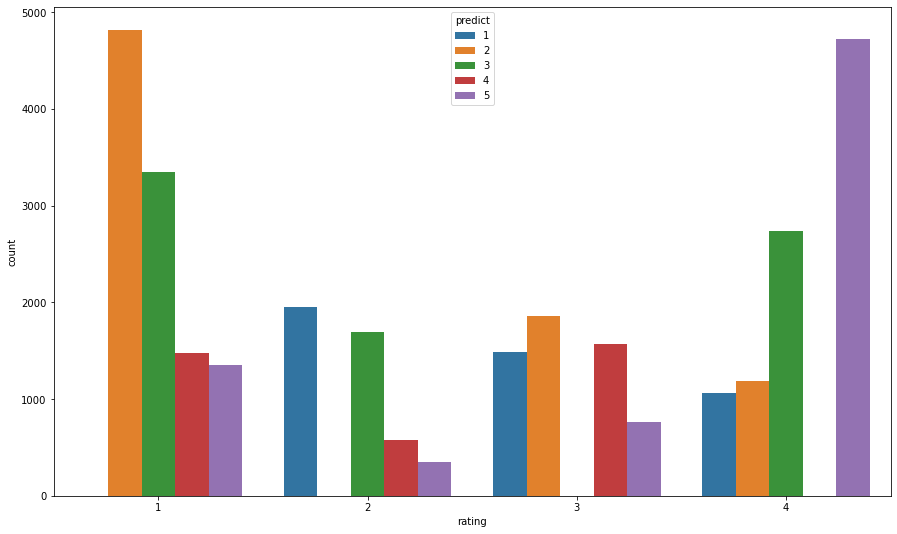

In [123]:
not5 = filtered[filtered['rating'] <= 4]

sns.countplot(x ='rating', data=filtered)
plt.show()
sns.countplot(x='rating', hue = 'predict', data=filtered)
plt.show()
plt.figure(figsize=(15,9))
sns.countplot(x='rating', hue = 'predict', data=not5)

In [124]:
filtered

podcast_id                     slug   category  \
12       ad4f2bf69c72b8db75978423c25f379e          ted talks daily       arts   
13       ad4f2bf69c72b8db75978423c25f379e          ted talks daily       arts   
14       ad4f2bf69c72b8db75978423c25f379e          ted talks daily  education   
18       ad4f2bf69c72b8db75978423c25f379e          ted talks daily       arts   
19       ad4f2bf69c72b8db75978423c25f379e          ted talks daily       arts   
...                                   ...                      ...        ...   
1425128  f3c611ee25d6b3f0efca2f2f86fb114b  stolen lives true crime    society   
1425134  bd39dd4c1a5d156af80b8b1ac8a8e50d           sleep whispers    society   
1425135  bd39dd4c1a5d156af80b8b1ac8a8e50d           sleep whispers    society   
1425155  f599da38fa69271b49f2dbbf56686874            conversations    society   
1425163  f9255ade54a8e12df362cde70b49dff9               the trypod     comedy   

                                                   content  rating  \
12                                            [love, good]       5   
13                                            [love, good]       5   
14                                            [love, good]       5   
18       [much, bs, trying, convince, racist, sexist, c...       3   
19       [much, bs, trying, convince, racist, sexist, c...       3   
...                                                    ...     ...   
1425128  [stories, sad, children, need, protected, keep...       5   
1425134  [one, top, asmr, sleep, whisper, podcasts, get...       5   
1425135  [one, top, asmr, sleep, whisper, podcasts, get...       5   
1425155  [richard, engaged, engaging, sarah, k, however...       5   
1425163  [really, crappy, ep, 2, 4, guess, winners, wou...       1   

                                                      lemm  polarity  \
12                                               love good  0.600000   
13                                               love good  0.600000   
14                                               love good  0.600000   
18       much b trying convince racist sexist country m...  0.200000   
19       much b trying convince racist sexist country m...  0.200000   
...                                                    ...       ...   
1425128  story sad child need protected keep good work ...  0.300000   
1425134  one top asmr sleep whisper podcasts get excite...  0.346591   
1425135  one top asmr sleep whisper podcasts get excite...  0.346591   
1425155  richard engaged engaging sarah k however like ...  0.400000   
1425163  really crappy ep 2 4 guess winner would really...  0.155363   

         subjectivity  predict  
12           0.600000        4  
13           0.600000        4  
14           0.600000        4  
18           0.200000        1  
19           0.200000        1  
...               ...      ...  
1425128      0.733333        3  
1425134      0.613636        1  
1425135      0.613636        1  
1425155      0.700000        4  
1425163      0.470611        4  

[249550 rows x 9 columns]

In [125]:
compare = dict(zip(np.array(filtered['rating'].value_counts().sort_index()), np.array(data['rating'].value_counts().sort_index())))
print(compare)

{10991: 60381, 4571: 25419, 5682: 29006, 9713: 41631, 218593: 1265761}


In [126]:
(np.array(filtered['rating']) - np.array(filtered['predict'])).mean()

1.5716690042075736

In [127]:
# filtered.to_pickle('./filtered')

In [141]:
# For graphing purposes

comp = pd.DataFrame()
for k, v in compare.items():
    print (round(k / v, 2))

# sns.countplot(x=compare)

0.18
0.18
0.2
0.23
0.17


In [129]:
type(compare)

dict

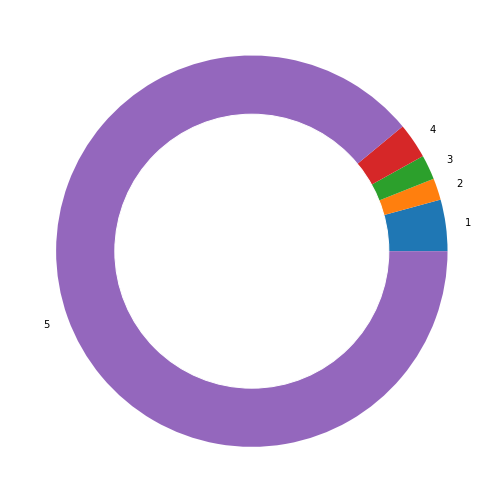

In [130]:
plt.figure(figsize=(15,9))

# create data
size_of_groups=[60381,25419,29006,41631,1265761]
 
# Create a pieplot
plt.pie(size_of_groups, labels=[1,2,3,4,5])
#plt.show()
 
# add a circle at the center
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
 
plt.show()


<AxesSubplot:ylabel='polarity'>

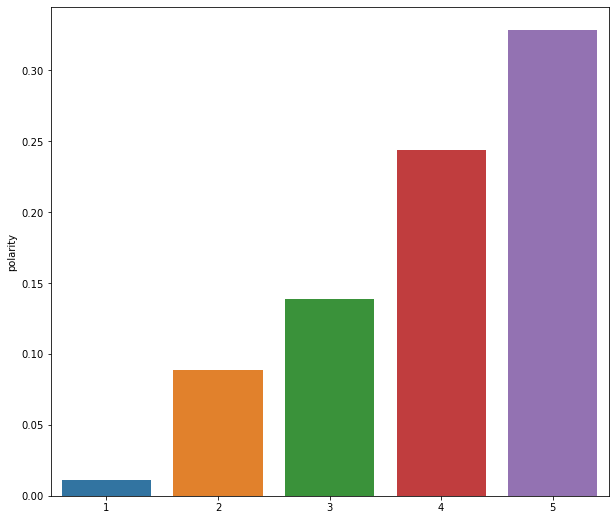

In [131]:
plt.figure(figsize=(10,9))
sns.barplot([1,2,3,4,5],data.groupby('rating')['polarity'].mean())

<AxesSubplot:xlabel='rating', ylabel='polarity'>

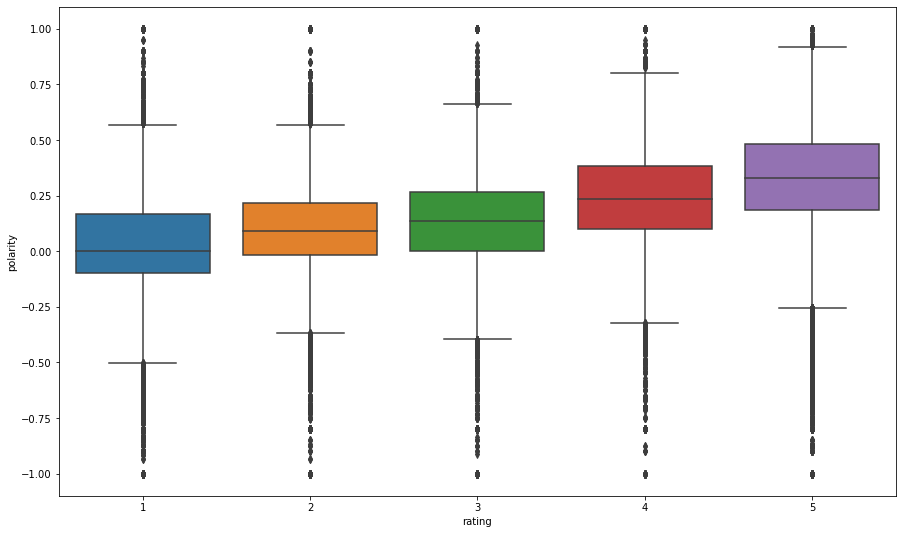

In [132]:
plt.figure(figsize=(15,9))
sns.boxplot(data['rating'],data['polarity'])